# Premiers Tests :
# Test des métriques axées sur l'aspect sémantique des schémas

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk import WordNetLemmatizer
from nltk import word_tokenize
import spicy
import scipy
import seaborn as sns

In [5]:
from tqdm.notebook import tqdm_notebook

In [6]:
with open('data/s/train_s.jsonl', 'r') as f:
  a = list(f)

data_s =[]
for element in a:
  data_s.append(json.loads(element))

data_s = pd.DataFrame(data_s)

In [7]:
with open('data/l/train_l.jsonl', 'r') as f:
  a = list(f)

data_l =[]
for element in a:
  data_l.append(json.loads(element))

data_l = pd.DataFrame(data_l)

In [8]:
with open('data/xl/train_xl.jsonl', 'r') as f:
  a = list(f)

data_xl =[]
for element in a:
  data_xl.append(json.loads(element))

data_xl = pd.DataFrame(data_xl)

* [$1^{ère}$ métrique : Clustering KMeans sur matrice de TFIDF](#first-bullet)
* [$2^{nd}$ métrique : Topic Modeling](#second-bullet)
* [$3^{ème}$ métrique : Sentence Embedding : SBERT](#third-bullet)
* [$4^{ème}$ métrique : Overlap Score (BM 25)](#fourth-bullet)
* [$5^{ème}$ métrique : Sentence Embedding : Google Universal Sentence Encoder](#fifth-bullet)
* [$6^{ème}$ métrique : Mutual Information](#sixth-bullet)

### $1^{ère}$ métrique : Clustering KMeans sur matrice de TDIDF <a class="anchor" id="first-bullet"></a>

Obtention d'une matrice de TF-IDF puis clustering avec KMeans cette matrice (2 cas : lemmatisées ou non)
Remarque sur les clusters obtenus:
- Ils ne sont pas très pertinents (pas logique sémantique dans le cluster)
- Ils ne sont pas impactés par la lemmatisation

Remarque sur les plots de distortions, inerties :
- Clusters optimaux pour envrion $n_{clusters} = 300$ (résultat logique car on retrouve approximativement 320 schéma "soeur" dans la base de données)

In [4]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data_s['sentence'])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

c:\users\marti\work\lattice-internship\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [138]:
clustering = KMeans(n_clusters=200)
clusters = clustering.fit_predict(df)
data_s['Cluster'] = clusters

In [145]:
data_s[data_s['cluster']==0]['sentence']

398    Have you ever been on  a nature walk Samantha ...
399    Have you ever been on  a nature walk Samantha ...
Name: sentence, dtype: object

In [101]:
def sentence_lemmatizer(sentence):
  WNL = WordNetLemmatizer()
  lemmatized=[]
  for word in word_tokenize(sentence):
    if word.isalpha():
      lemms = [WNL.lemmatize(word,pos=f'{param}') for param in ['v','n','a','r','s']]
      ind = np.argmin([len(lemm) for lemm in lemms])
      lemmatized.append(lemms[ind])
  return ' '.join(lemmatized)

In [20]:
data_s['lemmatized_sentence'] = data_s['sentence'].apply(sentence_lemmatizer)

In [142]:
data_s.head(2)

,qID,sentence,option1,option2,answer,cluster,cos,dist,lemmatized_sentence,cluster2,sentence_bow,Cluster
0,3QHITW7OYO7Q6B6ISU2UMJB84ZLAQE-2,Ian volunteered to eat Dennis's menudo after a...,Ian,Dennis,2,171,0.000000,0.000000,Ian volunteer to eat Dennis menudo after alrea...,0,"[ian, volunteer, eat, dennis, menudo, already,...",152
1,3QHITW7OYO7Q6B6ISU2UMJB84ZLAQE-1,Ian volunteered to eat Dennis's menudo after a...,Ian,Dennis,1,171,0.950838,0.443452,Ian volunteer to eat Dennis menudo after alrea...,0,"[ian, volunteer, eat, dennis, menudo, already,...",152


In [141]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data_s['lemmatized_sentence'])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df2 = pd.DataFrame(denselist,columns=feature_names)

c:\users\marti\work\lattice-internship\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [143]:
clustering = KMeans(200)
clusters = clustering.fit_predict(df2)
data_s['cluster2']= clusters

In [146]:
data_s[data_s['cluster2']==0]['sentence']

396    It took Jerry longer to shampoo his hair than ...
397    It took Jerry longer to shampoo his hair than ...
448    Jason's leg was more sore than his arm was bec...
449    Jason's leg was more sore than his arm was alt...
Name: sentence, dtype: object

In [45]:
distortions = []
inertias = []
from scipy.spatial.distance import cdist
K = range(1, 500)

for k in tqdm_notebook(K,desc = 'Progress Bar'):
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(df2)
    kmeanModel.fit(df2)

    distortions.append(sum(np.min(cdist(df2, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / df2.shape[0])
    inertias.append(kmeanModel.inertia_)

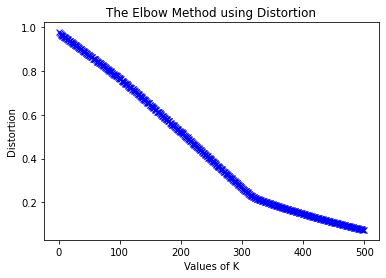

In [46]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

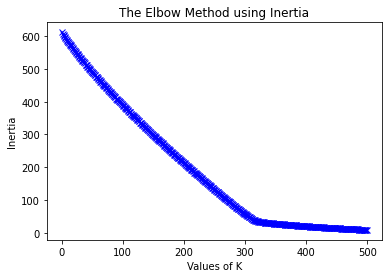

In [47]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Enregistrement de la matrice de tfidf pour des utilisations futures

In [13]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data_xl['sentence'])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
df_xl = pd.DataFrame(dense, columns=feature_names)

df_xl.to_csv('data/tf-idf/tf-idf-matrix.csv')

c:\users\marti\work\lattice-internship\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
def lemmatized_for_tfidf(sentence):
    return ' '.join(topic_modeling_preprocessing(sentence))

In [23]:
data_xl['lemmatized-sentence'] = [lemmatized_for_tfidf(sentence) for sentence in data_xl['sentence']]

In [24]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data_xl['lemmatized-sentence'])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
df_xl = pd.DataFrame(dense, columns=feature_names)

df_xl.to_csv('data/tf-idf/tf-idf-matrix-lemmatized.csv')

c:\users\marti\work\lattice-internship\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### $2^{nd}$ métrique : Topic Modeling <a class="anchor" id="second-bullet"></a>

La LDA sépare les phrases "soeurs" $\rightarrow$ il distingue donc la différence de sens entre ces phrases, malgré leur proximité lexicale

Note sur LDA : il s'appuie sur un algorithme de Gibbs Sampling (pas un algo de clustering)

In [102]:
from nltk.corpus import stopwords
import gensim
from gensim.corpora import Dictionary

In [103]:
def topic_modeling_preprocessing(sentence):
    WNL = WordNetLemmatizer()
    bow = [word.lower() for word in word_tokenize(sentence) if not word in stopwords.words('english')]
    preprocessed_bow = []
    for word in bow:
        if word.isalpha():
            lemms = [WNL.lemmatize(word,pos=f'{param}') for param in ['v','n','a','r','s']]
            ind = np.argmin([len(lemm) for lemm in lemms])
            preprocessed_bow.append(lemms[ind])
    return preprocessed_bow

In [104]:
data_s['sentence_bow'] = [topic_modeling_preprocessing(sentence) for sentence in list(data_s['sentence'])]

In [110]:
dictionary = Dictionary(list(data_s['sentence_bow']))
bow_corpus = [dictionary.doc2bow(doc) for doc in list(data_s['sentence_bow'])]

n_topics= 90
lda = gensim.models.LdaMulticore(bow_corpus,num_topics=n_topics,id2word=dictionary)

In [115]:
ex_list = [element[0] for element in lda.get_topic_terms(15)]
for element in ex_list:
    if element <= 640:
        print(data_s.iloc[element]['sentence'])
        print('----------')

Brian had a large collection of coins that Kevin really admired, so _ offered him some duplicates.
----------
The employees threw a party and drank so much alcohol that they could not go into work the next day. The _ was loud.
----------
To overcome behavioural bias, we need to focus more on changing the conscious actions instead of the unconscious actions because the _ actions are voluntary.
----------
Jessica took off the gloves and gave them to Katrina because _ 's hands were cold.
----------
Chess is bad for the body but great for the brain, as thinking is useless for the _ to develop.
----------
The experience was totally unforgettable for Betty but not Samantha because _ had anticipated it for months.
----------
Ben had to either stop eating chocolates or nuts. He chose to stop eating the _ because they were savory.
----------
The couple drank wine out of glasses instead of mugs, because the _ were clean.
----------


In [ ]:
dictionary = Dictionary(list(data_s['s']))

In [119]:
from gensim.models import CoherenceModel
# Compute Coherence Score
list_coherence = []
for i in tqdm_notebook(range(1,50)):
    if i%5 == 0:
        print(i)
    lda_model = lda = gensim.models.LdaMulticore(bow_corpus,
                                                 num_topics=i,
                                                 id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=list(data_s['sentence_bow']),
                                         dictionary=dictionary,
                                         coherence='c_v')
    list_coherence.append(coherence_model_lda.get_coherence())

5
10
15
20
25
30
35
40
45


In [121]:
for i in tqdm_notebook(range(51,70)):
    if i%5 == 0:
        print(i)
    lda_model = lda = gensim.models.LdaMulticore(bow_corpus,
                                                 num_topics=i,
                                                 id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=list(data_s['sentence_bow']),
                                         dictionary=dictionary,
                                         coherence='c_v')
    list_coherence.append(coherence_model_lda.get_coherence())

55
60
65


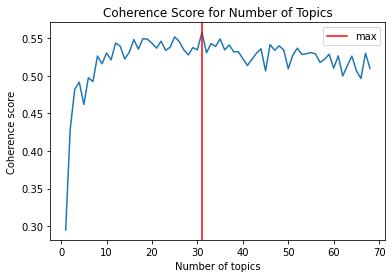

In [131]:
plt.plot(range(1,69),list_coherence)
plt.axvline(31,color='red',label='max')
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.title('Coherence Score for Number of Topics')
plt.legend()

Exemple de schema dans un topic pour $n_{topic}^{optimal}$

In [133]:
#opti lda
lda = gensim.models.LdaMulticore(bow_corpus,num_topics=31,id2word=dictionary)

In [148]:
ex_list = [element[0] for element in lda.get_topic_terms(15)]
for element in ex_list:
    if element <= 640:
        print(data_s.iloc[element]['sentence'])
        print('- - - - -')

The sushi rotted on the counter unless it was put in the cooler, as the _ exposed it to contamination.
- - - - -
Victoria was disgusted because of the odor of Sarah, and _ did not want to be around them.
- - - - -
Donald was richer than Leslie was because companies had found oil on the property of _ .
- - - - -
Once in Poland, Dennis enjoyed the trip more than Jason because _ had a deeper understanding of the Polish language.
- - - - -
I couldn't control the moisture like I controlled the rain, because the _ was coming in everywhere.
- - - - -
Emptying the litter box was a dreaded chore for Adam while Lawrence didn't mind doing it. _ never tried to get someone else to handle it.
- - - - -
To overcome behavioural bias, we need to focus more on changing the conscious actions instead of the unconscious actions because the _ actions are voluntary.
- - - - -
I installed a new bird house outside above the ground, but had to prop it up higher away from my cat since the _ was too low.
- - - - 

Idée pour l'établissement de la métrique basée sur cette méthode :
- réaliser le topic modeling sur la base de test pour $n_{topic}^{optimal}$ , fine-tuner ce modèle
- regarder la distribution de proba de l'appartenance de chaque document du training set aux différents topics du test set
- prendre, pour chaque document, la valeur de la proba d'appartenance maximale en guise de mesure ($\rightarrow$ plus un doc est sûr d'appartenir à un topic, plus il est précis et donc proche des phrases du cluster de ce topic)
- ordonner les docs du set d'entrainement en ordre croissant sur cette mesure, puis entrainer sur des buckets

### $3^{ème}$ métrique : Sentence Embedding : SBERT <a class="anchor" id="third-bullet"></a>

- Résultats plus intéressant que TFIDF : l'algo ne se limite pas à un travail de fréquence sur les mots. Le modèle intègre le sens de chaque mot et le contexte
- Le score semble assez discriminant : plot des moy, spreads, p-values des tests de normalité $\rightarrow$ il devrait être un bon indicateur de la quantification de la proximité sémantique des schéma

In [7]:
from sentence_transformers import SentenceTransformer

In [8]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [9]:
sentence_embeddings = model.encode(list(data_s['sentence']))

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
scores = np.zeros((sentence_embeddings.shape[0],sentence_embeddings.shape[0]))
for i in tqdm_notebook(range(sentence_embeddings.shape[0])):
    scores[i:] = cosine_similarity([sentence_embeddings[i]],sentence_embeddings)[0]

  0%|          | 0/640 [00:00<?, ?it/s]

c:\users\marti\work\lattice-internship\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution des cosine_similarity pour la phrase 0')

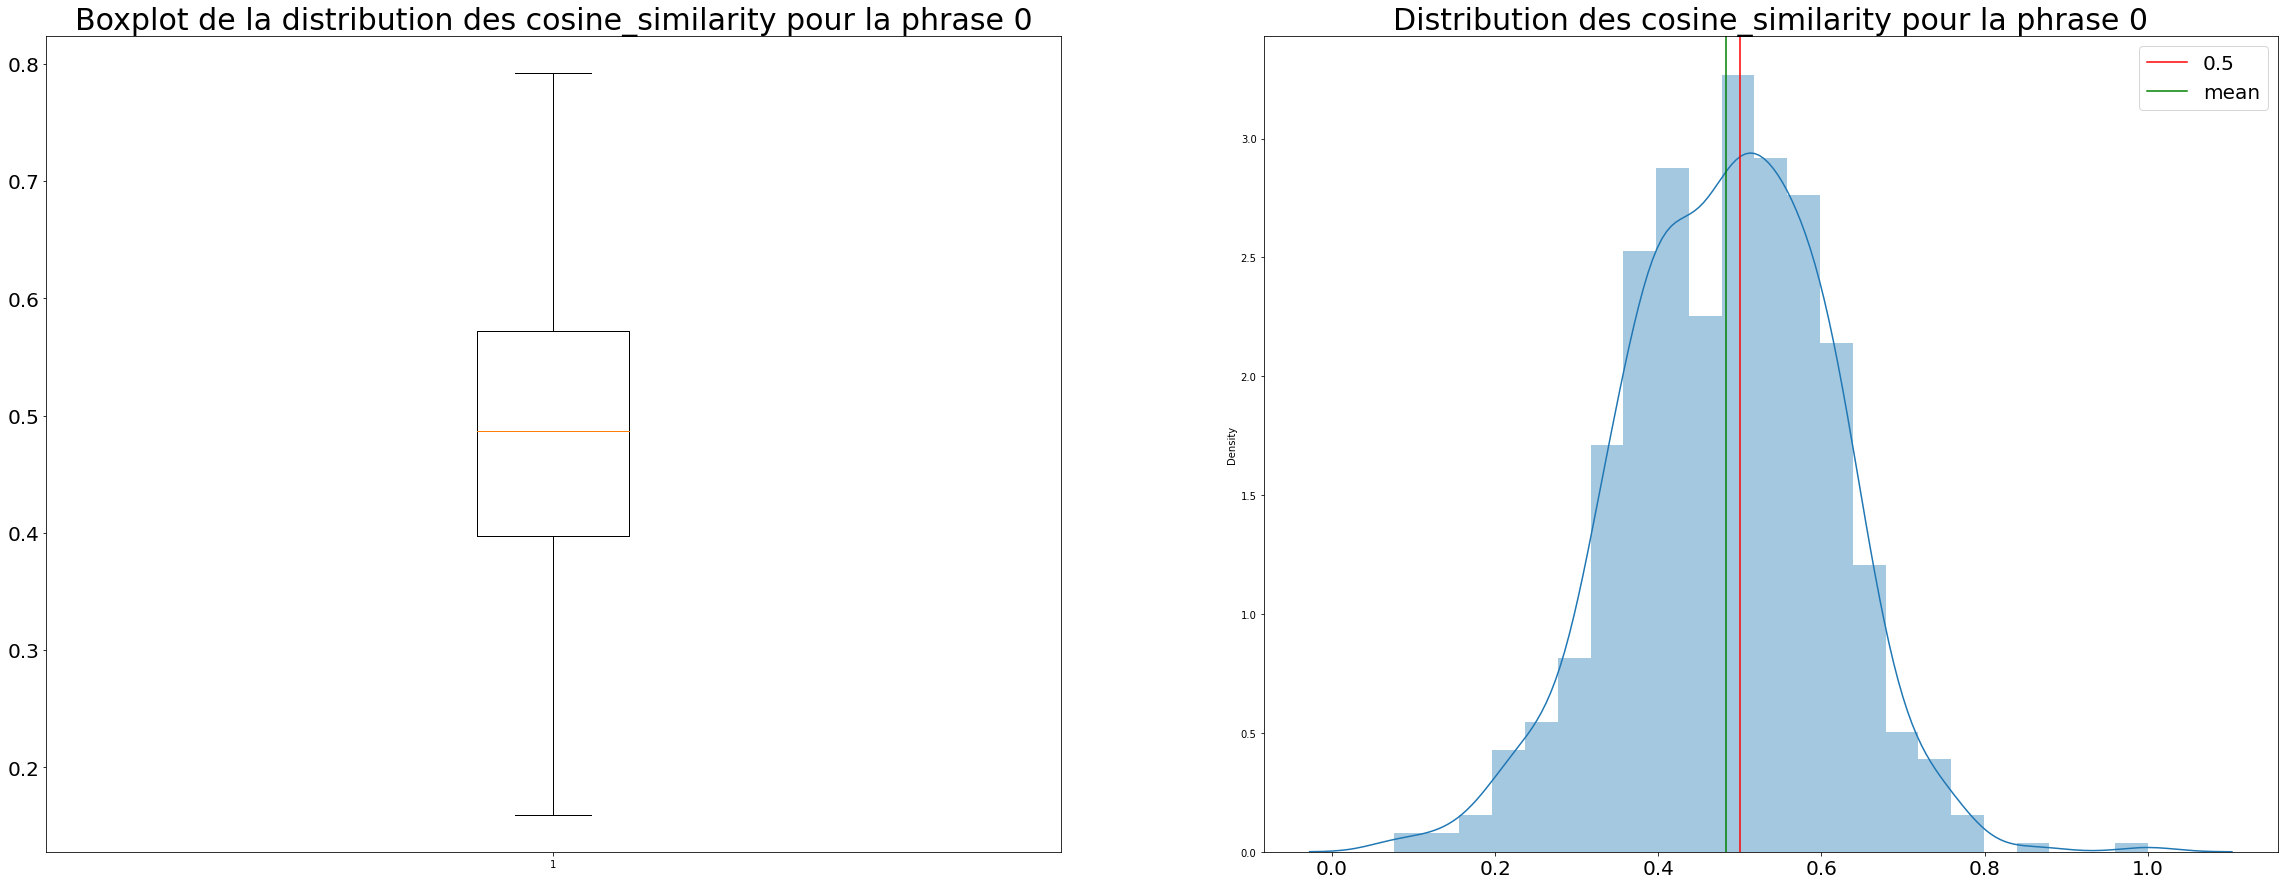

In [36]:
plt.figure(figsize=(40,15))
plt.subplot(1,2,1)
plt.boxplot(list(pd.DataFrame(scores)[0]),showfliers=False)
plt.title('Boxplot de la distribution des cosine_similarity pour la phrase 0',fontsize = 30)
plt.tick_params(axis = 'y', labelsize = 20)
plt.subplot(1,2,2)
sns.distplot(list(pd.DataFrame(scores)[0]))
plt.axvline(0.5,color='red',label='0.5')
plt.axvline(np.mean(list(pd.DataFrame(scores)[0])),color = 'green',label='mean')
plt.tick_params(axis = 'x', labelsize = 20)
plt.legend(fontsize=20)
plt.title('Distribution des cosine_similarity pour la phrase 0',fontsize = 30)

In [45]:
df_scores = pd.DataFrame(scores)

c:\users\marti\work\lattice-internship\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution des moyennes des cosine_similarity de data_s')

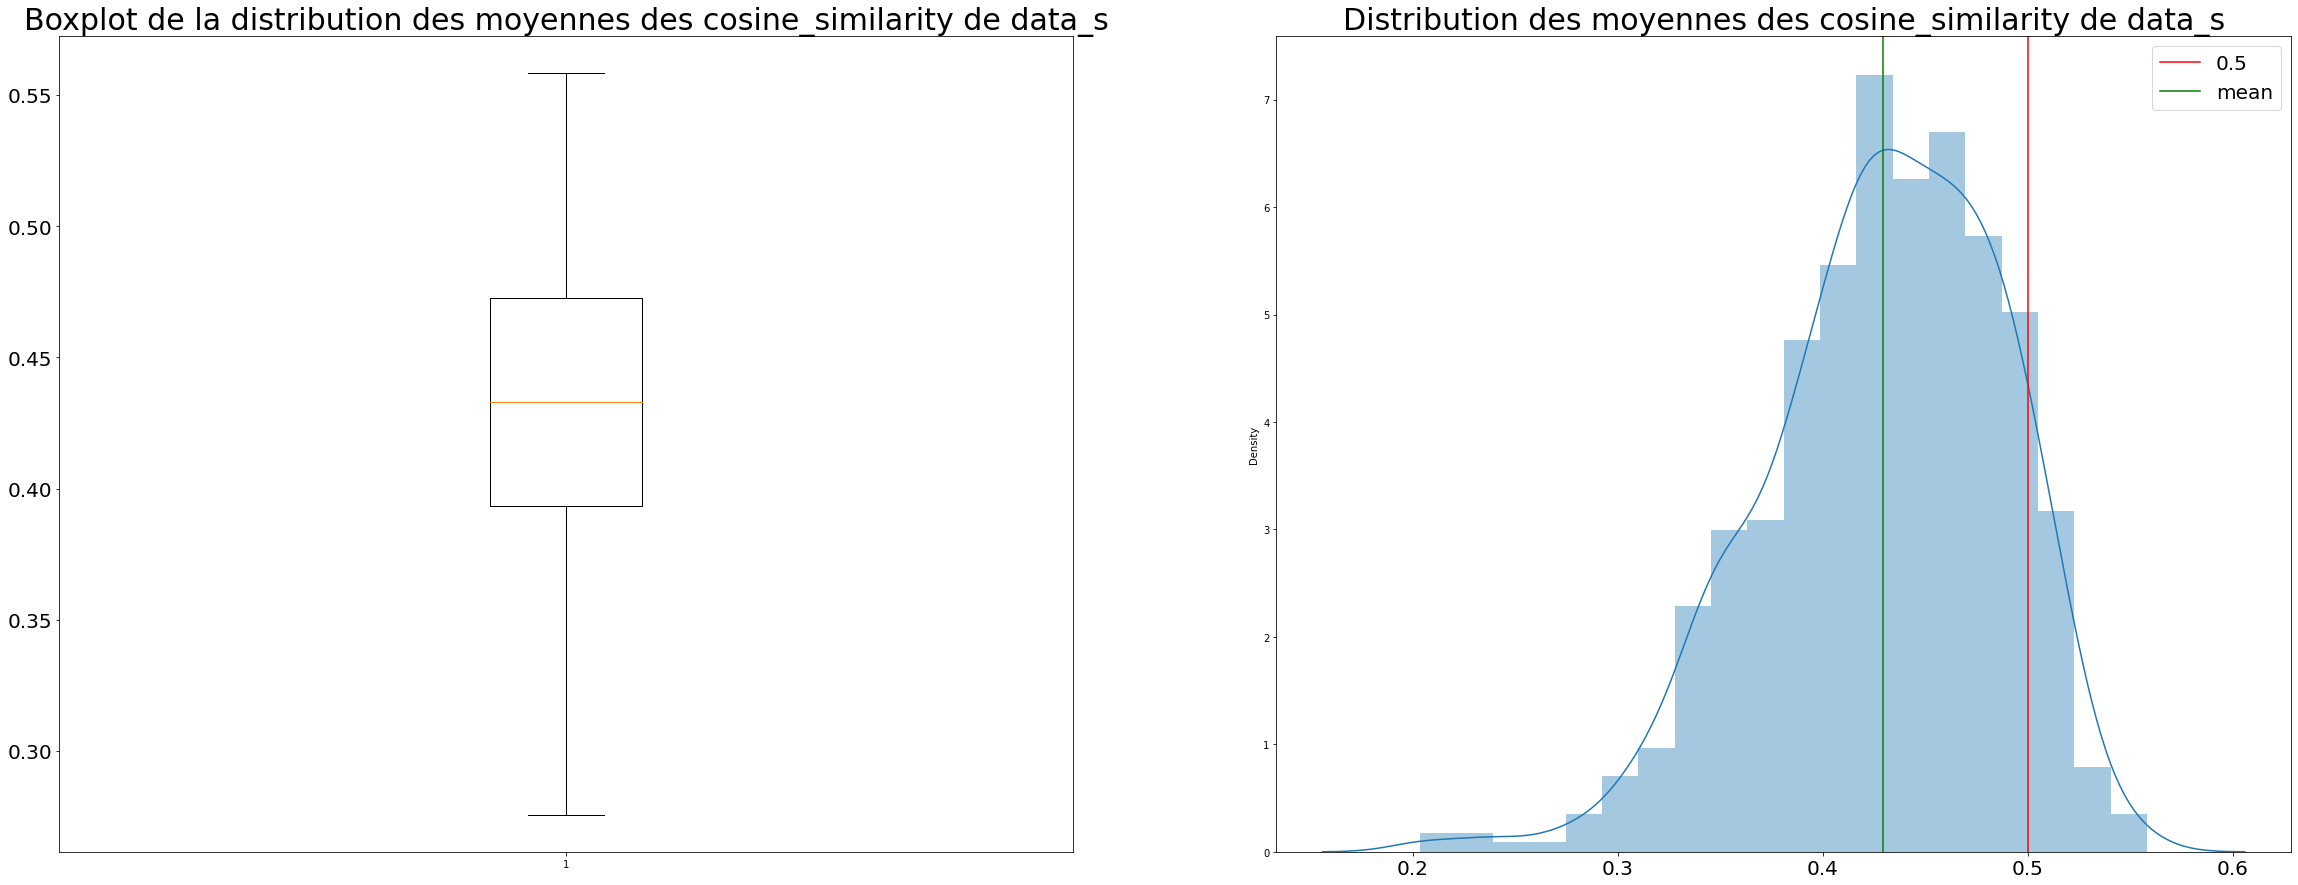

In [40]:
plt.figure(figsize=(40,15))
plt.subplot(1,2,1)
plt.boxplot(list(df_scores.mean()),showfliers=False)
plt.title('Boxplot de la distribution des moyennes des cosine_similarity de data_s',fontsize = 30)
plt.tick_params(axis = 'y', labelsize = 20)
plt.subplot(1,2,2)
sns.distplot(list(df_scores.mean()))
plt.axvline(0.5,color='red',label='0.5')
plt.axvline(np.mean(list(df_scores.mean())),color = 'green',label='mean')
plt.tick_params(axis = 'x', labelsize = 20)
plt.legend(fontsize=20)
plt.title('Distribution des moyennes des cosine_similarity de data_s',fontsize = 30)

c:\users\marti\work\lattice-internship\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution du spread des cosine_similarity de data_s')

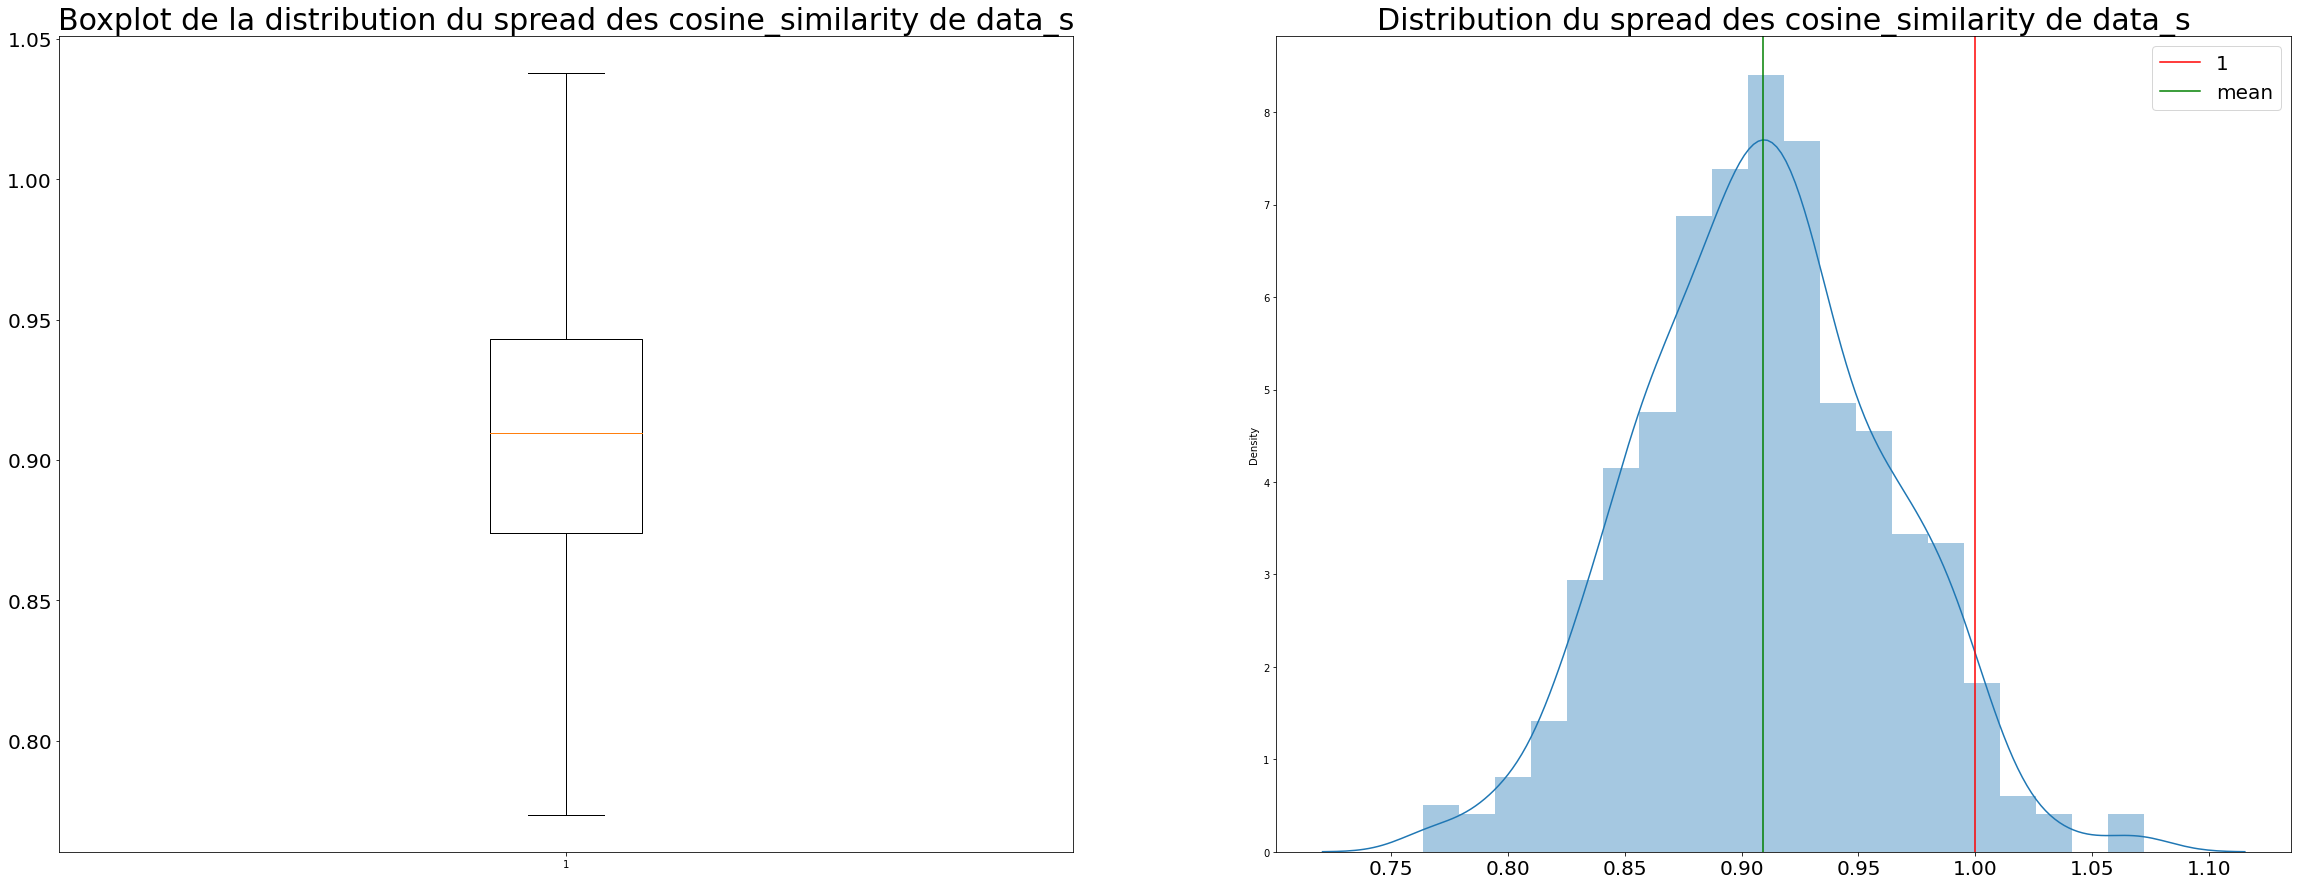

In [173]:
plt.figure(figsize=(40,15))
plt.subplot(1,2,1)
plt.boxplot(list(df_scores.max() - df_scores.min()),showfliers=False)
plt.title('Boxplot de la distribution du spread des cosine_similarity de data_s',fontsize = 30)
plt.tick_params(axis = 'y', labelsize = 20)
plt.subplot(1,2,2)
sns.distplot(list(df_scores.max() - df_scores.min()))
plt.axvline(1,color='red',label='1')
plt.axvline(np.mean(list(df_scores.max() - df_scores.min())),color = 'green',label='mean')
plt.tick_params(axis = 'x', labelsize = 20)
plt.legend(fontsize=20)
plt.title('Distribution du spread des cosine_similarity de data_s',fontsize = 30)

c:\users\marti\work\lattice-internship\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\marti\work\lattice-internship\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


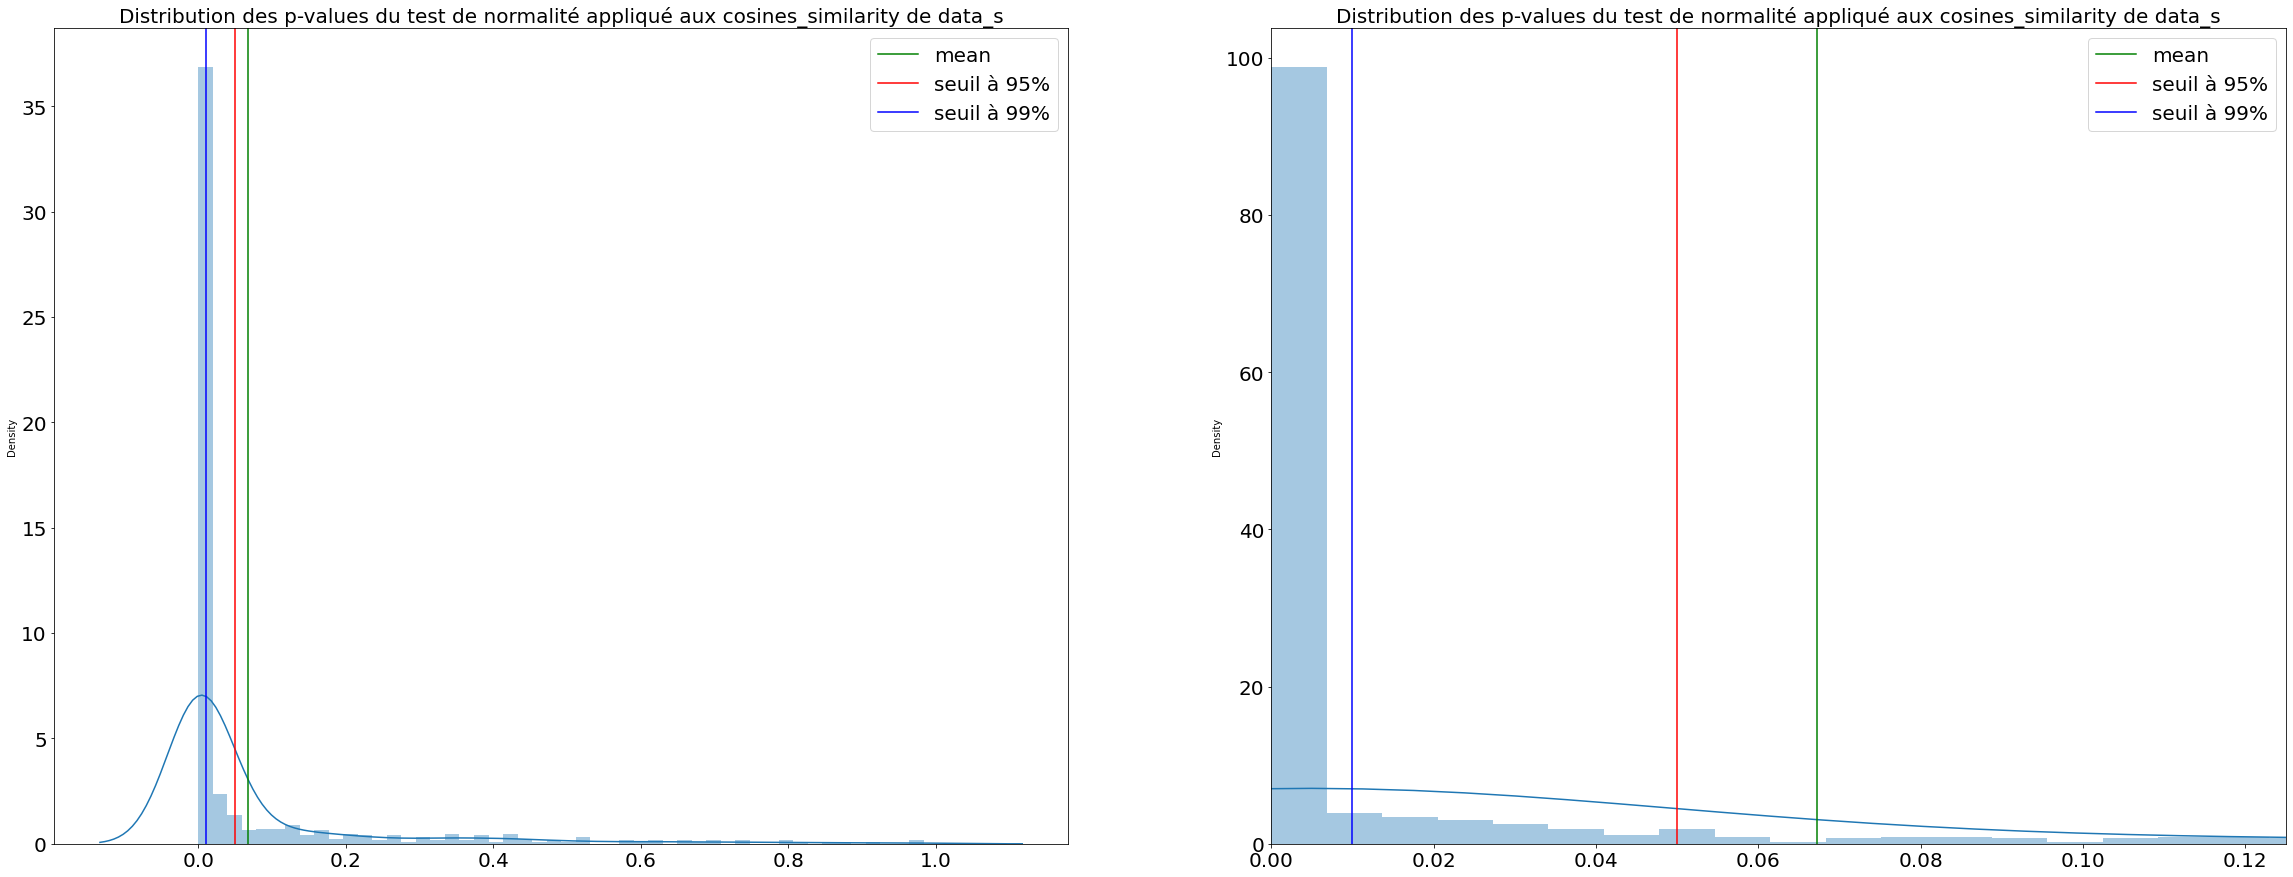

Pourcentage des phrases dont le test de normalité des cosine_similarity est vérifié à 90% : 0.8265625
Pourcentage des phrases dont le test de normalité des cosine_similarity est vérifié à 95% : 0.7890625
Pourcentage des phrases dont le test de normalité des cosine_similarity est vérifié à 99% : 0.6859375


In [86]:
list_pvalues=[scipy.stats.normaltest(df_scores[i])[1] for i in range(len(df_scores))]
plt.figure(figsize=(40,15))
plt.subplot(1,2,1)
sns.distplot(list_pvalues)
plt.axvline(np.mean(list_pvalues),color = 'green',label='mean')
plt.axvline(0.05,color = 'red',label='seuil à 95%')
plt.axvline(0.01,color = 'blue',label='seuil à 99%')
plt.tick_params(axis = 'x', labelsize = 20)
plt.tick_params(axis = 'y', labelsize = 20)
plt.legend(fontsize=20)
plt.title('Distribution des p-values du test de normalité appliqué aux cosines_similarity de data_s',fontsize = 20)
plt.subplot(1,2,2)
sns.distplot(list_pvalues,bins='auto')
plt.axvline(np.mean(list_pvalues),color = 'green',label='mean')
plt.axvline(0.05,color = 'red',label='seuil à 95%')
plt.axvline(0.01,color = 'blue',label='seuil à 99%')
plt.tick_params(axis = 'x', labelsize = 20)
plt.tick_params(axis = 'y', labelsize = 20)
plt.legend(fontsize=20)
plt.title('Distribution des p-values du test de normalité appliqué aux cosines_similarity de data_s',fontsize = 20)
plt.xlim(0,0.125)
plt.show()
compteur90 = sum([1 for i in list_pvalues if i <=0.1])
compteur95 = sum([1 for i in list_pvalues if i <=0.05])
compteur99 = sum([1 for i in list_pvalues if i <=0.01])
print(f'Pourcentage des phrases dont le test de normalité des cosine_similarity est vérifié à 90% : {compteur90/len(list_pvalues)}')
print(f'Pourcentage des phrases dont le test de normalité des cosine_similarity est vérifié à 95% : {compteur95/len(list_pvalues)}')
print(f'Pourcentage des phrases dont le test de normalité des cosine_similarity est vérifié à 99% : {compteur99/len(list_pvalues)}')

In [168]:
scores_for_print = df_scores.reset_index()
int_ = np.random.randint(0,len(scores_for_print))
print('        ----- Voici les 3 phrases les plus proches de la phrase suivante : -----' )
print(data_s.iloc[int_]['sentence'])
print('---------------')
for i in scores_for_print.sort_values(int_,ascending=False)['index'][1:4]:
    print('-' , data_s.iloc[i]['sentence'])

        ----- Voici les 3 phrases les plus proches de la phrase suivante : -----
Monica enjoyed watching Western films while Natalie enjoyed romantic ones more because _ grew up on a farm.
---------------
- Monica enjoyed watching Western films while Natalie enjoyed romantic ones more because _ grew up watching soap operas.
- Jordan gave his miniature horse a field and a barn to stay in, and the horse liked the _ better when it was cold.
- Jordan gave his miniature horse a field and a barn to stay in, and the horse liked the _ better when it was warm.


Extraction des données pour le dataset complet : (à run lorsque 2h de dispo) \
Vérifier les différentes hypothèses de normalité/distribution sur le dataset complet

In [44]:
sentence_embeddings_xl = model.encode(list(data_xl['sentence']))
scores_xl = np.zeros((sentence_embeddings_xl.shape[0],sentence_embeddings_xl.shape[0]))
for i in tqdm_notebook(range(sentence_embeddings_xl.shape[0])):
    scores_xl[i:] = cosine_similarity([sentence_embeddings_xl[i]],sentence_embeddings_xl)[0]

MemoryError: Unable to allocate 12.2 GiB for an array with shape (40398, 40398) and data type float64

In [ ]:
sentence_embeddings_xl = model.encode(list(data_xl['sentence']))

In [ ]:
sentence_embeddings_xl = sentence_embeddings_xl.to_numpy()
list_scores = []
for i in tqdm_notebook(range(sentence_embeddings_xl.shape[0])):
    list_scores.append(
        cosine_similarity([sentence_embeddings_xl[i]],sentence_embeddings_xl)[0]
    )

In [ ]:
scores_xl = pd.DataFrame(scores_xl)
scores_xl.to_csv('data/bert/similarity_bert_encoding.csv')

In [45]:
sentence_embeddings_xl = pd.DataFrame(sentence_embeddings_xl)
sentence_embeddings_xl.to_csv('data/bert/sentences_bert_768_encoding')

Méthodo pour évaluation progressive du modèle avec cette métrique:
- Calculer les scores de cosine_similarity pour chaque schéma du training set avec l'intégralité des schéma du test set
- Ordonner en ordre croissant les schémas du training set selon la moyenne/médiane/écart-interquartile/max (*à déterminer*) des cosine_similarity avec le test set
- Découper le training set en 10 (*ou 20, 100 ?? à déterminer*) portions de tailles égale
- Entrainer progressivement et évaluer le modèle sur 10%, puis 20% ... (*à déterminer aussi*) du training set ordonné

### $4^{ème}$ métrique : Overlap Score (BM 25) <a class="anchor" id="fourth-bullet"></a>

Tests sur plusieurs modèles d'overlap score (BM25 $\rightarrow$ version améliorée d'un score de TF-IDF) : BM25Okapi, BM25L, BM25Plus \
Les résultats obtenus (phrase les plus proches) ne sont pas pertinents

In [87]:
from rank_bm25 import *

##### Modèle BM25Okapi

In [108]:
bm25_model = BM25Okapi(list(data_s['sentence_bow']))
list_bm25scores =[]
for sentence in tqdm_notebook(list(data_s['sentence_bow'])):
    list_bm25scores.append(bm25_model.get_scores(sentence))

  0%|          | 0/640 [00:00<?, ?it/s]

In [109]:
df_bm25scores = pd.DataFrame(list_bm25scores)

In [118]:
df_bm25scores.reset_index().sort_values(7,ascending=False)

,index,0,1,2,3,4,5,6,7,8,...,630,631,632,633,634,635,636,637,638,639
6,6,0.000000,0.000000,6.839595,6.839595,0.0,0.0,45.734660,41.970806,0.0,...,1.236299,1.236299,0.000000,0.000000,0.000000,0.000000,1.236299,1.236299,1.236299,1.236299
7,7,0.000000,0.000000,6.839595,6.839595,0.0,0.0,40.277913,41.970806,0.0,...,1.236299,1.236299,0.000000,0.000000,0.000000,0.000000,1.236299,1.236299,1.236299,1.236299
348,348,0.000000,0.000000,5.912296,5.912296,0.0,0.0,8.286393,8.649950,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.127404,4.127404
349,349,0.000000,0.000000,5.912296,5.912296,0.0,0.0,8.286393,8.649950,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.127404,4.127404
20,20,0.000000,0.000000,8.868444,8.868444,0.0,0.0,7.750222,8.090255,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,113,3.854408,3.854408,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
357,357,0.000000,0.000000,3.417126,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,2.894632,2.894632,0.000000,0.000000,2.894632,2.894632,0.000000,0.000000,0.000000,0.000000
356,356,0.000000,0.000000,0.000000,3.516448,0.0,0.0,0.000000,0.000000,0.0,...,2.894632,2.894632,0.000000,0.000000,2.894632,2.894632,0.000000,0.000000,0.000000,0.000000
355,355,4.815177,4.815177,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,3.808804,3.808804,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [128]:
print(data_s.iloc[7]['sentence'])
print('---------')
for i in [348,20,300,162,344]:
    print(data_s.iloc[i]['sentence'])

The GPS and map helped me navigate home.  I got lost when the _ got turned off.
---------
My knee joint is less injured than my ankle joint so I'm trying not to put too much stress on the _ if I can help it.
I picked up a bag of peanuts and raisins for a snack. I wanted a sweeter snack out so I stored the _ for now.
I went into the mine looking for diamonds but all I found was quartz and topaz.  I settled on the _ because it was almost clear.
Brian wanted to be a home based administrative assistant and Kenneth didn't because _ liked staying at home.
The case James used to carry the file still got more space in it. I wonder why he chose the _ that is small.


##### Modèle BM25L

In [121]:
bm25_model2 = BM25L(list(data_s['sentence_bow']))
list_bm25scores2 =[]
for sentence in tqdm_notebook(list(data_s['sentence_bow'])):
    list_bm25scores2.append(bm25_model2.get_scores(sentence))

  0%|          | 0/640 [00:00<?, ?it/s]

In [122]:
df_bm25scores2= pd.DataFrame(list_bm25scores2)
df_bm25scores2.reset_index().sort_values(7,ascending=False)

,index,0,1,2,3,4,5,6,7,8,...,630,631,632,633,634,635,636,637,638,639
6,6,0.000000,0.000000,8.534533,8.534533,0.0,0.0,66.763009,60.941780,0.0,...,1.859838,1.859838,0.000000,0.000000,0.000000,0.000000,1.859838,1.859838,1.859838,1.859838
7,7,0.000000,0.000000,8.534533,8.534533,0.0,0.0,59.602305,60.941780,0.0,...,1.859838,1.859838,0.000000,0.000000,0.000000,0.000000,1.859838,1.859838,1.859838,1.859838
345,345,0.000000,0.000000,3.716091,8.094162,0.0,0.0,12.391577,12.663955,0.0,...,1.859838,1.859838,0.000000,0.000000,0.000000,0.000000,1.859838,1.859838,5.613335,5.613335
344,344,0.000000,0.000000,7.975776,3.716091,0.0,0.0,12.391577,12.663955,0.0,...,1.859838,1.859838,0.000000,0.000000,0.000000,0.000000,1.859838,1.859838,5.613335,5.613335
562,562,0.000000,0.000000,0.000000,0.000000,0.0,0.0,11.337254,11.585568,0.0,...,0.000000,0.000000,0.000000,0.000000,4.818442,4.818442,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,113,4.877596,4.877596,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
357,357,0.000000,0.000000,4.259685,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,3.644425,3.644425,0.000000,0.000000,3.644425,3.644425,0.000000,0.000000,0.000000,0.000000
356,356,0.000000,0.000000,0.000000,4.378071,0.0,0.0,0.000000,0.000000,0.0,...,3.644425,3.644425,0.000000,0.000000,3.644425,3.644425,0.000000,0.000000,0.000000,0.000000
355,355,10.671129,10.671129,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,4.638537,4.638537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [129]:
print(data_s.iloc[7]['sentence'])
print('---------')
for i in [345,562,349,286,20]:
    print(data_s.iloc[i]['sentence'])

The GPS and map helped me navigate home.  I got lost when the _ got turned off.
---------
The case James used to carry the file still got more space in it. I wonder why he chose the _ that is big.
Natalie helped Monica to get into a treatment program, after _ told of her drug addiction.
My knee joint is more injured than my ankle joint so I'm trying not to put too much stress on the _ if I can help it.
I used several sprays to get rid of the bedbugs but they didn't work, because the _ were powerless.
I picked up a bag of peanuts and raisins for a snack. I wanted a sweeter snack out so I stored the _ for now.


##### Modèle BM25Plus

In [124]:
bm25_model3 = BM25Plus(list(data_s['sentence_bow']))
list_bm25scores3 =[]
for sentence in tqdm_notebook(list(data_s['sentence_bow'])):
    list_bm25scores3.append(bm25_model3.get_scores(sentence))
df_bm25scores3= pd.DataFrame(list_bm25scores3)

  0%|          | 0/640 [00:00<?, ?it/s]

In [125]:
df_bm25scores2.reset_index().sort_values(7,ascending=False)

,index,0,1,2,3,4,5,6,7,8,...,630,631,632,633,634,635,636,637,638,639
6,6,0.000000,0.000000,8.534533,8.534533,0.0,0.0,66.763009,60.941780,0.0,...,1.859838,1.859838,0.000000,0.000000,0.000000,0.000000,1.859838,1.859838,1.859838,1.859838
7,7,0.000000,0.000000,8.534533,8.534533,0.0,0.0,59.602305,60.941780,0.0,...,1.859838,1.859838,0.000000,0.000000,0.000000,0.000000,1.859838,1.859838,1.859838,1.859838
345,345,0.000000,0.000000,3.716091,8.094162,0.0,0.0,12.391577,12.663955,0.0,...,1.859838,1.859838,0.000000,0.000000,0.000000,0.000000,1.859838,1.859838,5.613335,5.613335
344,344,0.000000,0.000000,7.975776,3.716091,0.0,0.0,12.391577,12.663955,0.0,...,1.859838,1.859838,0.000000,0.000000,0.000000,0.000000,1.859838,1.859838,5.613335,5.613335
562,562,0.000000,0.000000,0.000000,0.000000,0.0,0.0,11.337254,11.585568,0.0,...,0.000000,0.000000,0.000000,0.000000,4.818442,4.818442,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,113,4.877596,4.877596,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
357,357,0.000000,0.000000,4.259685,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,3.644425,3.644425,0.000000,0.000000,3.644425,3.644425,0.000000,0.000000,0.000000,0.000000
356,356,0.000000,0.000000,0.000000,4.378071,0.0,0.0,0.000000,0.000000,0.0,...,3.644425,3.644425,0.000000,0.000000,3.644425,3.644425,0.000000,0.000000,0.000000,0.000000
355,355,10.671129,10.671129,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,4.638537,4.638537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [130]:
print(data_s.iloc[7]['sentence'])
print('---------')
for i in [345,562,349,286,20]:
    print(data_s.iloc[i]['sentence'])

The GPS and map helped me navigate home.  I got lost when the _ got turned off.
---------
The case James used to carry the file still got more space in it. I wonder why he chose the _ that is big.
Natalie helped Monica to get into a treatment program, after _ told of her drug addiction.
My knee joint is more injured than my ankle joint so I'm trying not to put too much stress on the _ if I can help it.
I used several sprays to get rid of the bedbugs but they didn't work, because the _ were powerless.
I picked up a bag of peanuts and raisins for a snack. I wanted a sweeter snack out so I stored the _ for now.


##### BM25 by gensim

Supprimé de la librairie

#### $5^{ème}$ métrique : Sentence Embedding : Google Universal Sentence Encoder <a class="anchor" id="fifth-bullet"></a>

D'après la littérature, il s'agit d'un des modèles de sentence embedding les plus performants aujourd'hui

On observe que la distribution du score obtenu sur ces vecteurs est assez discriminante. \
La moyenne des scores obtenus avec cet embedding est plus faible. La façon avec laquelle cet embedding est conçu fait que la similarité cosine a moins facilement tendance à dire que deux schéma sont très corrélés $\rightarrow$ ce résultat peut être intéressant car cela voudrait dire que le peu de phrases étant jugées très corrélées le seront vraiment (*à vérifier*)

In [132]:
import tensorflow as tf
import tensorflow_hub as hub

In [133]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [135]:
sentence_embeddings_use = model(list(data_s['sentence']))

In [136]:
scores_use = np.zeros((sentence_embeddings_use.shape[0],sentence_embeddings_use.shape[0]))
for i in tqdm_notebook(range(sentence_embeddings_use.shape[0])):
    scores_use[i:] = cosine_similarity([sentence_embeddings_use[i]],sentence_embeddings_use)[0]

  0%|          | 0/640 [00:00<?, ?it/s]

In [137]:
df_scores_use = pd.DataFrame(scores_use)

In [139]:
scores_use_for_print = df_scores_use.reset_index()
int_ = np.random.randint(0,len(scores_use_for_print))
print('        ----- Voici les 3 phrases les plus proches de la phrase suivante : -----' )
print(data_s.iloc[int_]['sentence'])
print('---------------')
for i in scores_use_for_print.sort_values(int_,ascending=False)['index'][1:4]:
    print('-' , data_s.iloc[i]['sentence'])

        ----- Voici les 3 phrases les plus proches de la phrase suivante : -----
Joseph decided to groom their dog in the waiting room unlike Leslie, so _ had the dirtier dog.
---------------
- Joseph decided to groom their dog in the waiting room unlike Leslie, so _ had the cleaner dog.
- The dog's hair had to be removed after it got stuck in the mud because the _ was clean.
- The dog's hair had to be removed after it got stuck in the mud because the _ was disgusting.


In [138]:
df_scores_use

,0,1,2,3,4,5,6,7,8,9,...,630,631,632,633,634,635,636,637,638,639
0,1.000000,0.959811,0.006830,0.001415,0.132720,0.148199,0.062759,0.062163,-0.035743,-0.022884,...,0.094687,0.117668,0.251124,0.219915,0.061667,0.097801,0.122516,0.106154,0.201263,0.191347
1,0.959811,1.000000,0.001826,0.004870,0.109227,0.130901,0.079549,0.075812,-0.029826,-0.020553,...,0.079827,0.094606,0.233736,0.206346,0.062515,0.096488,0.123619,0.104526,0.195146,0.178609
2,0.006830,0.001826,1.000000,0.968834,0.099488,0.082291,0.250057,0.235020,0.008905,0.026006,...,0.027100,0.046870,0.051570,0.031097,-0.047733,-0.003170,0.260796,0.269943,0.064114,0.091425
3,0.001415,0.004870,0.968834,1.000000,0.093868,0.078281,0.252139,0.235112,0.021249,0.035026,...,0.031858,0.047220,0.057325,0.040747,-0.034191,-0.011792,0.240795,0.255229,0.091172,0.098656
4,0.132720,0.109227,0.099488,0.093868,1.000000,0.982999,0.002057,0.022527,0.039727,0.045494,...,0.077521,0.068608,0.222937,0.236904,0.141344,0.172621,0.008209,0.018952,0.072626,0.083508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.097801,0.096488,-0.003170,-0.011792,0.172621,0.153643,-0.041793,-0.024782,0.209151,0.214179,...,-0.032274,-0.001351,0.302546,0.294946,0.925065,1.000000,0.082462,0.085495,0.139558,0.145629
636,0.122516,0.123619,0.260796,0.240795,0.008209,0.007798,0.188847,0.197545,0.124298,0.141359,...,0.131984,0.195101,0.179437,0.166206,0.052243,0.082462,1.000000,0.975397,0.162223,0.169239
637,0.106154,0.104526,0.269943,0.255229,0.018952,0.015995,0.208430,0.206831,0.157421,0.167379,...,0.153310,0.215089,0.188405,0.176844,0.058530,0.085495,0.975397,1.000000,0.200245,0.202604
638,0.201263,0.195146,0.064114,0.091172,0.072626,0.059962,0.122262,0.143635,0.137837,0.130433,...,0.184916,0.237060,0.103127,0.113161,0.139161,0.139558,0.162223,0.200245,1.000000,0.957706


c:\users\marti\work\lattice-internship\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\marti\work\lattice-internship\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\marti\work\lattice-internship\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

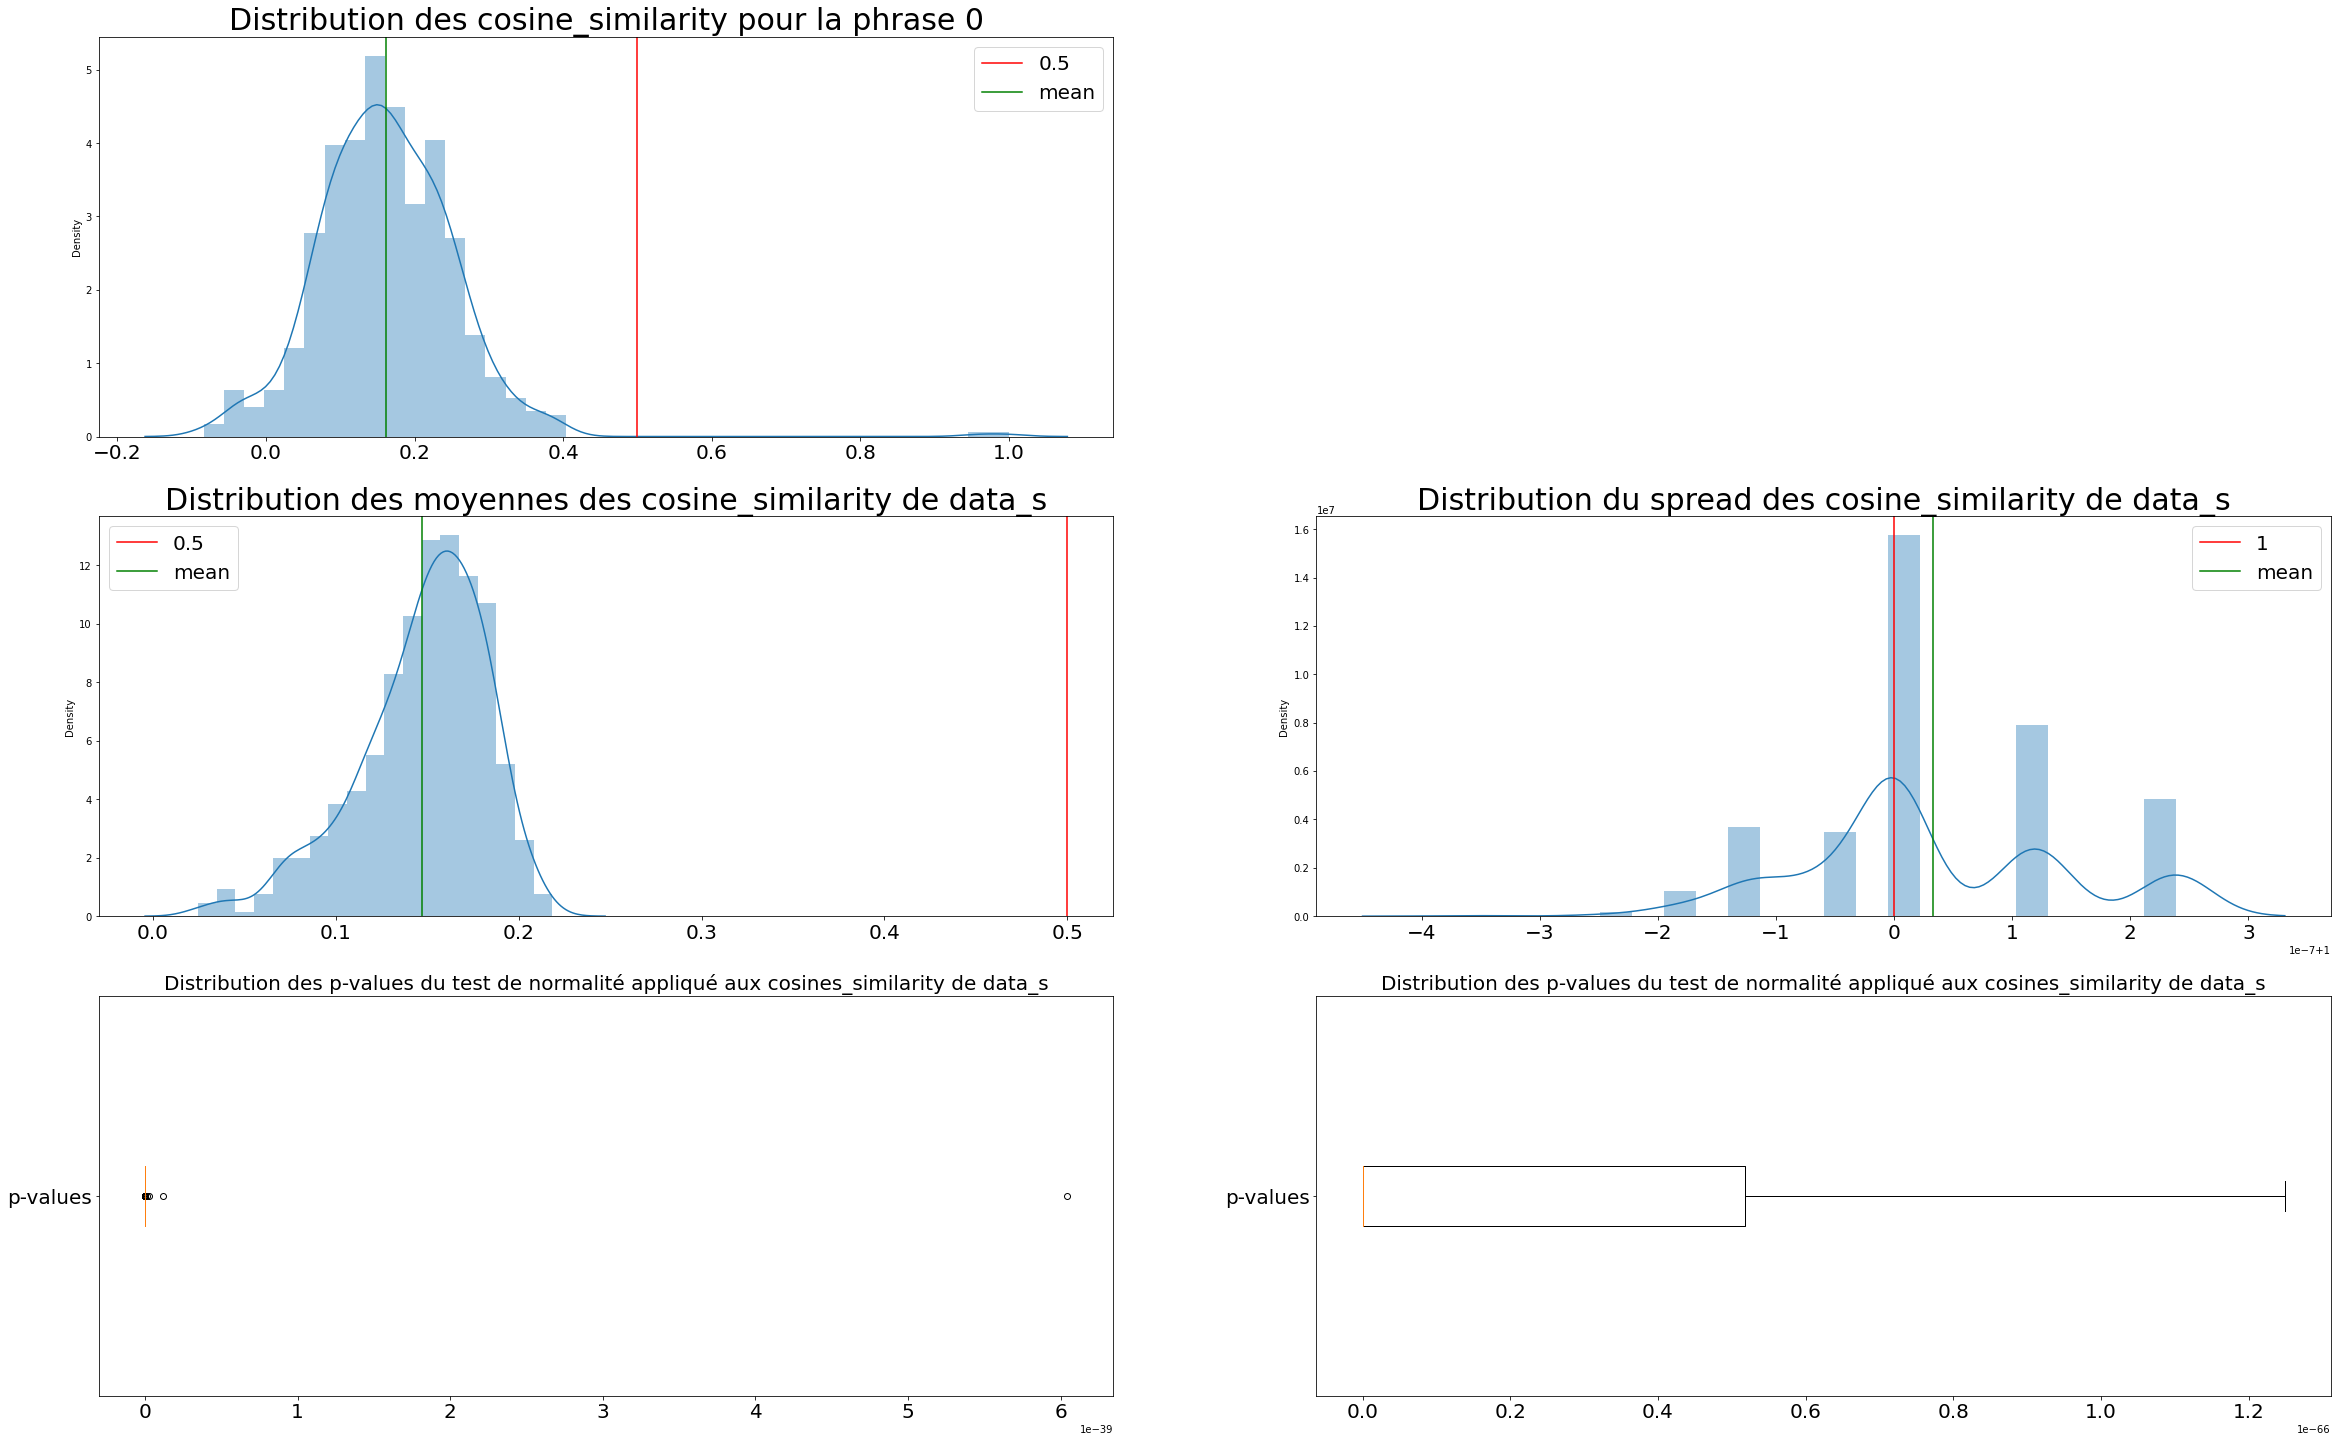

Pourcentage des phrases dont le test de normalité des cosine_similarity est vérifié à 90% : 1.0
Pourcentage des phrases dont le test de normalité des cosine_similarity est vérifié à 95% : 1.0
Pourcentage des phrases dont le test de normalité des cosine_similarity est vérifié à 99% : 1.0


In [172]:
plt.figure(figsize=(40,25))
plt.subplot(3,2,1)
sns.distplot(list(df_scores_use[0]))
plt.axvline(0.5,color='red',label='0.5')
plt.axvline(np.mean(list(df_scores_use[0])),color = 'green',label='mean')
plt.tick_params(axis = 'x', labelsize = 20)
plt.legend(fontsize=20)
plt.title('Distribution des cosine_similarity pour la phrase 0',fontsize = 30)

plt.subplot(3,2,3)
sns.distplot(list(df_scores_use.mean()))
plt.axvline(0.5,color='red',label='0.5')
plt.axvline(np.mean(list(df_scores_use.mean())),color = 'green',label='mean')
plt.tick_params(axis = 'x', labelsize = 20)
plt.legend(fontsize=20)
plt.title('Distribution des moyennes des cosine_similarity de data_s',fontsize = 30)

plt.subplot(3,2,4)
sns.distplot(list(df_scores_use.max() - df_scores_use.min()))
plt.axvline(1,color='red',label='1')
plt.axvline(np.mean(list(df_scores_use.max() - df_scores_use.min())),color = 'green',label='mean')
plt.tick_params(axis = 'x', labelsize = 20)
plt.legend(fontsize=20)
plt.title('Distribution du spread des cosine_similarity de data_s',fontsize = 30)

plt.subplot(3,2,5)

list_pvalues_use = [scipy.stats.normaltest(df_scores_use[i])[1] for i in range(len(df_scores_use))]

plt.boxplot(list_pvalues_use,
            showfliers=True, vert=False, labels=['p-values'])
plt.title('Distribution des p-values du test de normalité appliqué aux cosines_similarity de data_s',fontsize = 20)
plt.tick_params(axis='x',labelsize=20)
plt.tick_params(axis='y',labelsize=20)

plt.subplot(3,2,6)
plt.boxplot(list_pvalues_use,
            showfliers=False, vert=False, labels=['p-values'])
plt.title('Distribution des p-values du test de normalité appliqué aux cosines_similarity de data_s',fontsize = 20)
plt.tick_params(axis='x',labelsize=20)
plt.tick_params(axis='y',labelsize=20)
plt.show()


compteur90 = sum([1 for i in list_pvalues_use if i <=0.1])
compteur95 = sum([1 for i in list_pvalues_use if i <=0.05])
compteur99 = sum([1 for i in list_pvalues_use if i <=0.01])
print(f'Pourcentage des phrases dont le test de normalité des cosine_similarity est vérifié à 90% : {compteur90/len(list_pvalues_use)}')
print(f'Pourcentage des phrases dont le test de normalité des cosine_similarity est vérifié à 95% : {compteur95/len(list_pvalues_use)}')
print(f'Pourcentage des phrases dont le test de normalité des cosine_similarity est vérifié à 99% : {compteur99/len(list_pvalues_use)}')

#### $6^{ème}$ métrique : Mutual Information <a class="anchor" id="sixth-bullet"></a>

Problèmes :
    - Pas de librairie/dataset contenant les probas d'apparition des différents mots
    - Trop difficilement généralisable sur autre chose que des paires de mots (pas forcément très pertinent)

## Conclusion sur des premiers tests sur les métriques axées sémantique

- 6 métriques d'essayées:
    - Clustering sur TF-IDF
    - Topic Modeling (LDA)
    - Sentence Embedding (SBERT)
    - Overlap Score (BM25Okapi, BM25+, BM25L)
    - Sentence Embedding (Google Universal Sentence Encoder)
- Métriques intéréressantes :
    - 1.Sentence Embedding (SBERT + GUSE), 2.Topic Modeling (LDA), 3.TF-IDF
- La nature du problème semble faire que les métriques les plus intéressantes pour l'aspect sémantique sont celles qui ne se basent pas exclusivement sur les fréquences d'apparition des mots dans les phrases/corpus. Les schémas ne sont pas assez longs (seulement une à deux phrases) pour prendre l'aspect fréquentiel pertinent. La généralisation de méthodes axées sur les mots (donc indépendemment du contexte, comme la Mutual Information) n'est pas pertinente non plus.
- Les résultats des modèles d'embedding sont intéressant :
    - En leur appliquant la similarité cosinus, les scores obtenus permettent de discriminer les phrases entre elles : on s'approche d'une distribution normale avec une amplitude proche de 1 (pour un score allant entre 0 et 1 (*voir comment traiter résultats négatifs*).
    - Facilement généralisables
- Les modèles d'embedding semblent donc ceux à privilégier. A voir quel modèle est le plus pertinent, que ce soit entre SBERT et GUSE, ou encore avec d'autres modèles non exploités (Skip-Thoughts, Quick-Thoughts, InferSent, MILA/MSR General Purpose Sent. ...)
- Le fine-tuning des modèles d'embedding devrait permettre de perfectionner encore les résultats obtenus.

# Test des métriques axées sur l'aspect syntaxique des schémas

#### $1^{ère}$ métrique : Constituency Trees avec Jaccard Similarity

Constituency Trees : Arbre gardant la structure du schema, mais "replaçant" chaque mot par un tag décrivant sa fonction (verbe, sujet, adjectif...)

Remarques :
- Mesure intéressante : discriminante
- Difficile de juger les clusters de tête, néanmoins les mathématiques simples sur lesquels ils s'appuient devrait confirmer la pertinence
- Différents points à comparer/tester : `jaccard_similarity` avec ou sans éléments dupliqués, retenir ou non les combinaisons de 1 élément dans `combinaison_generator`, regrouper certains tags sous un unique tag dans `get_list_chunkz`

In [9]:
import spacy
from nltk import Tree


en_nlp = spacy.load('en_core_web_sm')

doc = en_nlp("The quick brown fox jumps over the lazy dog.")

def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_


[to_nltk_tree(sent.root).pretty_print() for sent in doc.sents]

        jumps                    
  ________|______________         
 |        |             over     
 |        |              |        
 |       fox            dog      
 |    ____|_____      ___|____    
 .  The quick brown the      lazy



[None]

In [10]:
doc = en_nlp("Ian volunteered to eat Dennis's menudo after already having a bowl because _ enjoyed eating intestine.")
[to_nltk_tree(sent.root).pretty_print() for sent in doc.sents]
for sent in doc.sents:
    print(to_nltk_tree(sent.root))

                   volunteered                               
  ______________________|_______                              
 |   |                         eat                           
 |   |    ______________________|______                       
 |   |   |    |                      after                   
 |   |   |    |                        |                      
 |   |   |    |                      having                  
 |   |   |    |          ______________|_______               
 |   |   |  menudo      |       |           enjoyed          
 |   |   |    |         |       |       _______|________      
 |   |   |  Dennis      |      bowl    |       |      eating 
 |   |   |    |         |       |      |       |        |     
Ian  .   to   's     already    a   because    _    intestine

(volunteered
  Ian
  (eat
    to
    (menudo (Dennis 's))
    (after
      (having
        already
        (bowl a)
        (enjoyed because _ (eating intestine)))))
  .)


In [13]:
import nltk
from nltk import pos_tag
from nltk.corpus import treebank

nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [20]:
import ast

In [14]:
import svgling

In [18]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [33]:
def get_list_chunkz(sentence):
    tok_sent = word_tokenize(sentence)
    tok_tag_sent = pos_tag(tok_sent)
    entities = nltk.chunk.ne_chunk(tok_tag_sent)
    lit_entities = ast.literal_eval(str(list(entities)).replace("(",'[').replace(")","]").replace("Tree",''))
    list_ =[]
    for i in lit_entities :
        if len(i[1][0]) >=2:
            list_.append(i[1][0][1])
        else:
            list_.append(i[1])
    return list_

In [91]:
def combinaison_generator(list_):
    comb = []
    #print(len(list_))
    for length in range(2,len(list_)+1):
        for index in range(0,len(list_)+1-length):
            #print(len(list_)+1-length)
            comb.append(list_[index:index+length])
    return comb

In [104]:
from collections import Counter

In [105]:
def jaccard_similarity(list1, list2):
    intersection = len(list((Counter(list1) & Counter(list2)).elements()))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [106]:
phrases = list(data_s['sentence'])
chunkz_sentences = [get_list_chunkz(phrase) for phrase in tqdm_notebook(phrases,desc='chunkz')]
comb_sentences = [combinaison_generator(chunk) for chunk in tqdm_notebook(chunkz_sentences,desc='combinaisons')]
mat_sim = []
for i in tqdm_notebook(range(len(phrases)),desc='matrice1'):
    mat_sim.append([jaccard_similarity(phrases[i],phrases[j]) for j in range(len(phrases))])
df_jacc_s = pd.DataFrame(mat_sim)

chunkz:   0%|          | 0/640 [00:00<?, ?it/s]

combinaisons:   0%|          | 0/640 [00:00<?, ?it/s]

matrice1:   0%|          | 0/640 [00:00<?, ?it/s]

In [108]:
df_jacc_s.sort_values(0,ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,630,631,632,633,634,635,636,637,638,639
0,1.000000,0.915888,0.559322,0.550847,0.602941,0.602941,0.557377,0.516667,0.561404,0.573913,...,0.611111,0.632000,0.671875,0.674603,0.650407,0.647541,0.626016,0.626016,0.657895,0.637931
1,0.915888,1.000000,0.564103,0.555556,0.595588,0.595588,0.549180,0.521008,0.566372,0.578947,...,0.590551,0.611111,0.651163,0.653543,0.655738,0.652893,0.617886,0.617886,0.620690,0.601695
67,0.724409,0.730159,0.551181,0.555556,0.593103,0.582192,0.585938,0.535433,0.552846,0.564516,...,0.611940,0.643939,0.644928,0.647059,0.636364,0.621212,0.613636,0.601504,0.603175,0.585938
340,0.720339,0.726496,0.675926,0.636364,0.653846,0.641221,0.584746,0.556522,0.576577,0.561404,...,0.709402,0.717949,0.715447,0.719008,0.709402,0.692308,0.683761,0.683761,0.675676,0.654867
360,0.719008,0.669355,0.589744,0.581197,0.560284,0.549296,0.573770,0.533333,0.538462,0.564103,...,0.708333,0.731092,0.728000,0.745902,0.737288,0.705882,0.655738,0.642276,0.675439,0.641026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,0.486957,0.491228,0.655556,0.626374,0.464000,0.452381,0.597938,0.615385,0.625000,0.622222,...,0.570093,0.579439,0.516949,0.530435,0.541284,0.537037,0.542056,0.556604,0.621053,0.614583
114,0.483051,0.487179,0.514851,0.551020,0.438462,0.416667,0.514286,0.525253,0.580645,0.595745,...,0.522124,0.517544,0.512397,0.525424,0.549550,0.545455,0.522523,0.495575,0.519231,0.500000
30,0.474138,0.478261,0.674157,0.626374,0.464000,0.452381,0.581633,0.597826,0.606742,0.604396,...,0.541284,0.550459,0.504202,0.517241,0.527273,0.522936,0.513761,0.527778,0.604167,0.597938
60,0.468254,0.483871,0.582524,0.572816,0.539062,0.515385,0.495575,0.518868,0.618557,0.600000,...,0.516667,0.500000,0.507812,0.496063,0.504132,0.487603,0.516949,0.516949,0.513514,0.495575


In [110]:
#jacquard avec duplicates
for i in [61,30,114,567,393]: #pires
#for i in [1,67,340,360,326]: #meilleurs
    print(chunkz_sentences[i])
    print(chunkz_sentences[0])
    print('-------')
    print(data_s['sentence'][0])
    print(data_s['sentence'][i])
    print('-------')

['NN', 'VBD', 'RB', 'NNP', 'TO', 'VB', 'TO', 'VB', 'DT', 'NN', ',', 'RB', 'JJ', 'VBD', 'DT', 'NN', 'NN', '.']
['NNP', 'VBD', 'TO', 'VB', 'NNP', 'POS', 'NN', 'IN', 'RB', 'VBG', 'DT', 'NN', 'IN', 'NNP', 'VBD', 'VBG', 'NN', '.']
-------
Ian volunteered to eat Dennis's menudo after already having a bowl because _ despised eating intestine.
Rebecca picked up Amy to carpool to work every day, so _ offered some gas money.
-------
['DT', 'NN', 'VBD', 'RP', 'RB', 'JJ', 'NN', 'IN', 'DT', 'NN', ',', 'IN', 'DT', 'NN', 'VBD', 'JJ', '.']
['NNP', 'VBD', 'TO', 'VB', 'NNP', 'POS', 'NN', 'IN', 'RB', 'VBG', 'DT', 'NN', 'IN', 'NNP', 'VBD', 'VBG', 'NN', '.']
-------
Ian volunteered to eat Dennis's menudo after already having a bowl because _ despised eating intestine.
The plant took up too much room in the urn, because the _ was small.
-------
['NNP', 'VBD', 'DT', 'JJR', 'NN', 'IN', 'NNP', 'IN', 'NNP', 'VBD', 'PRP$', 'NN', 'RB', 'RBR', 'NN', '.']
['NNP', 'VBD', 'TO', 'VB', 'NNP', 'POS', 'NN', 'IN', 'RB', '

In [101]:
#jacquard en mode set
#for i in [332,628,145,99,358]: #pires
for i in [1,33,160,340,96,136]: #meilleurs
    print(chunkz_sentences[i])
    print(chunkz_sentences[0])
    print('-------')
    print(data_s['sentence'][0])
    print(data_s['sentence'][i])
    print('-------')

['NNP', 'VBD', 'TO', 'VB', 'NNP', 'POS', 'NN', 'IN', 'RB', 'VBG', 'DT', 'NN', 'IN', 'NNP', 'VBD', 'VBG', 'NN', '.']
['NNP', 'VBD', 'TO', 'VB', 'NNP', 'POS', 'NN', 'IN', 'RB', 'VBG', 'DT', 'NN', 'IN', 'NNP', 'VBD', 'VBG', 'NN', '.']
-------
Ian volunteered to eat Dennis's menudo after already having a bowl because _ despised eating intestine.
Ian volunteered to eat Dennis's menudo after already having a bowl because _ enjoyed eating intestine.
-------
['PRP', 'VBD', 'DT', 'JJ', 'NN', 'NN', 'IN', 'IN', 'DT', 'NN', ',', 'CC', 'VBD', 'TO', 'VB', 'PRP', 'RP', 'JJR', 'RB', 'IN', 'PRP$', 'NN', 'IN', 'DT', 'NN', 'VBD', 'RB', 'JJ', '.']
['NNP', 'VBD', 'TO', 'VB', 'NNP', 'POS', 'NN', 'IN', 'RB', 'VBG', 'DT', 'NN', 'IN', 'NNP', 'VBD', 'VBG', 'NN', '.']
-------
Ian volunteered to eat Dennis's menudo after already having a bowl because _ despised eating intestine.
I installed a new bird house outside above the ground, but had to prop it up higher away from my cat since the _ was too high.
-------
[

c:\users\marti\work\lattice-internship\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\marti\work\lattice-internship\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\marti\work\lattice-internship\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

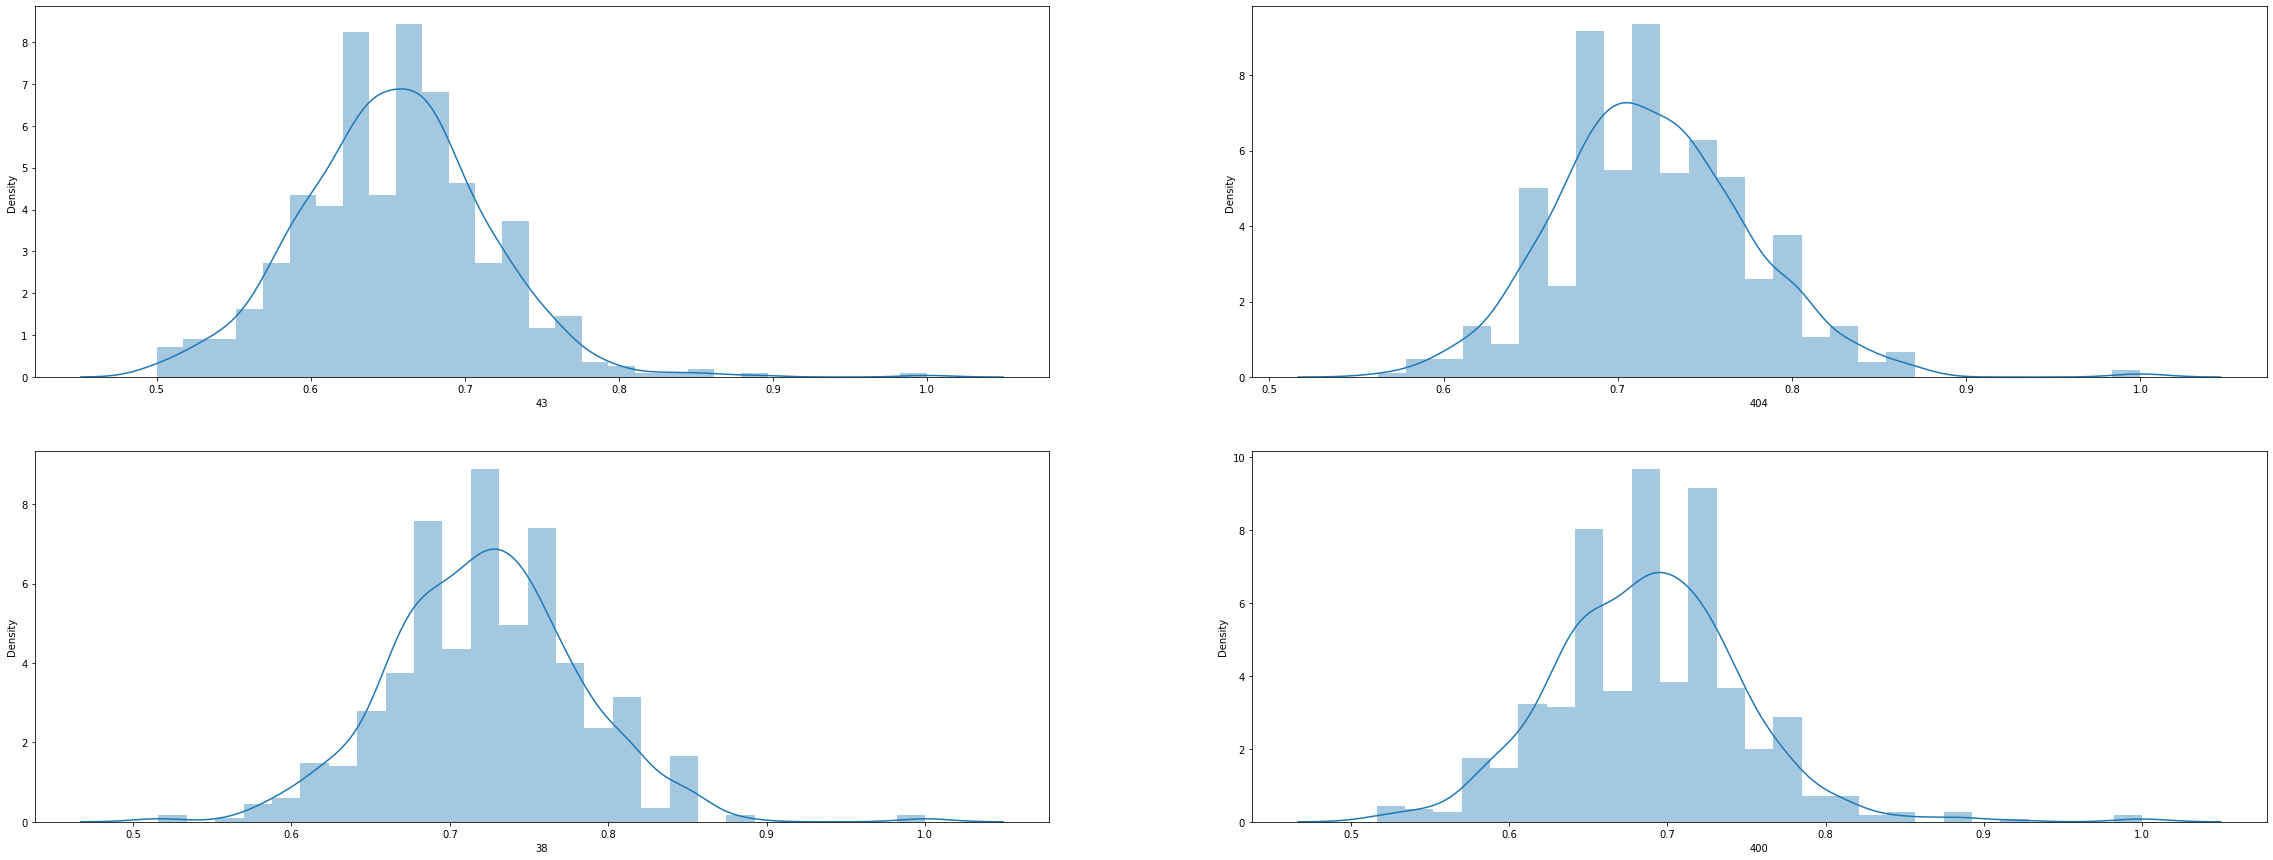

In [86]:
plt.figure(figsize=(40,15))
for i in range(4):
    plt.subplot(2,2,i+1)
    j = np.random.randint(0,639)
    sns.distplot(df_jacc_s[j])